## Домашнее задание №1


#### Тема: Языковое моделирование и определение языка.


**Выдана**:   14 сентября 2017

**Дедлайн**:   <font color='red'>9:00 утра 28 сентября 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 3)

#### Правила:

Результат выполнения задания $-$ отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев $-$ тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 3). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе Вам предстоит реализовать n-грамную языковую модель с несколькими видами сглаживания:
- Add-one smoothing
- Stupid backoff
- Interpolation smoothing
- Kneser-Ney smoothing

Вы обучите ее на готовых корпусах, оцените качество и проведете ряд экспериментов. Во второй части задания Вы примените реализованную модель (но с буквенными n-граммами) к задаче распознавания языка. 


# Языковые модели

Цель языкового моделирования заключается в том, чтобы присвоить некоторые вероятности предложениям. Задача состоит в подсчете вероятности $P(W) = P(w_1, \dots, w_n)$ или $P(w_n \mid w_1, \dots, w_{n-1})$. Модель, умеющая вычислять хотя бы одну из этих двух вероятностей, называется **языковой моделью** (LM от Language Model).

Согласно **цепному правилу** (chain rule):

$$P(X_1, \dots, X_n) = P(X_1)P(X_2 \mid X_1)\dots P(X_n \mid X_1, \dots, X_{n-1}).$$ 

Также мы знаем, что

$$
    P(X_n \mid X_1, \dots, X_{n-1}) = \frac{P(X_1, \dots, X_n)}{P(X_1, \dots, X_{n-1})},
$$

следовательно, для того чтобы оценить $P(X_n \mid X_1, \dots, X_{n-1})$ нужно посчитать $P(X_1, \dots, X_n)$ и $P(X_1, \dots, X_{n-1})$. Но эти вероятности будут чрезвычайно малы, если мы возьмем большое $n$, так множество предложений из $n$ слов растет экспоненциально. Для упрощения применим **марковское предположение**: 

$$P(X_n \mid X_1, \dots, X_{n-1}) = P(X_n \mid X_{n - k + 1}, \dots, X_{n-1})$$

для некоторого фиксированного (небольшого) $k$. Это предположение говорит о том, что $X_{n}$ не зависит от $X_{1}, \dots, X_{n - k}$, то есть на следующее слово влияет лишь контекст из предыдущих $k - 1$ слова. Таким образом, мы получаем финальную вероятность:

$$
    P(w_1, \dots, w_n) = \prod_i P(w_i \mid w_{i-k+1}, \dots, w_{i - 1}).
$$

Далее для краткости будем обозначать $w_{i-k}^i := w_{i-k}, \dots, w_{i}$.

## Хранилище n-грам

Для начала выполним вспомогательную работу. Следуйте комментариям, чтобы написать NGramStorage с удобным интерфейсом.

In [1]:
import re
import math
import random
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
class NGramStorage:
    """Storage for ngrams' frequencies.

    Args:
        sents (list[list[str]]): List of sentences from which ngram
            frequencies are extracted.
        max_n (int): Upper bound of the length of ngrams.
            For instance if max_n = 2, then storage will store
            0, 1, 2-grams.

    Attributes:
        max_n (Readonly(int)): Upper bound of the length of ngrams.
    """

    def __init__(self, sents=[], max_n=0):
        self.__max_n = max_n
        self.__ngrams = {i: Counter() for i in range(self.__max_n + 1)}
        # self._ngrams[K] should have the following interface:
        # self._ngrams[K][(w_1, ..., w_K)] = number of times w_1, ..., w_K occured in words
        # self._ngrams[0][()] = number of all words
        
        ### YOUR CODE HERE
        def handle_sentence(sentence):
            for length in range(1, max_n + 1):
                for i in range(len(sentence)):
                    new_n_gram = tuple(sentence[i:(i + length)])
                    if len(new_n_gram) == length:
                        self.__ngrams[length][new_n_gram] += 1
                        if length == 1:
                            self.__ngrams[0][tuple()] += 1
        for sentence in sents:
            handle_sentence(sentence)
        ### END YOUR CODE
        
    def add_unk_token(self):
        """Add UNK token to 1-grams."""
        # In order to avoid zero probabilites 
        if self.__max_n == 0 or 'UNK' in self.__ngrams[1]:
            return
        self.__ngrams[0][()] += 1
        self.__ngrams[1][('UNK', )] = 1
        
    @property
    def max_n(self):
        """Get max_n"""
        return self.__max_n
        
    def __getitem__(self, k):
        """Get dictionary of k-gram frequencies.
        
        Args:
            k (int): length of returning ngrams' frequencies.
            
        Returns:
            Dictionary (in fact Counter) of k-gram frequencies.
        """
        # Cheking the input
        if not isinstance(k, int):
            raise TypeError('k (length of ngrams) must be an integer!')
        if k > self.__max_n:
            raise ValueError('k (length of ngrams) must be less or equal to the maximal length!')
        return self.__ngrams[k]
    
    def __call__(self, ngram):
        """Return frequency of a given ngram.
        
        Args:
            ngram (tuple): ngram for which frequency should be computed.
            
        Returns:
            Frequency (int) of a given ngram.
        """
        # Cheking the input
        if not isinstance(ngram, tuple):
            raise TypeError('ngram must be a tuple!')
        if len(ngram) > self.__max_n:
            raise ValueError('length of ngram must be less or equal to the maximal length!')
        if len(ngram) == 1 and ngram not in self.__ngrams[1]:
            return self.__ngrams[1][('UNK', )]
        return self.__ngrams[len(ngram)][ngram]

## Оценка качества

Скачайте brown корпус, обучите модель и протестируйте на нескольких примерах последовательностей.

In [3]:
import nltk
# Uncomment next row and download brown corpus
# nltk.download()
from nltk.corpus import brown

In [4]:
all_sents = list(brown.sents())
random.shuffle(all_sents)
print('Number of all sentences = {}'.format(len(all_sents)))
train_sents = all_sents[:int(0.8 * len(all_sents))]
test_sents = all_sents[int(0.8 * len(all_sents)):]
print('Number of train sentences = {}'.format(len(train_sents)))
print('Number of test sentences = {}'.format(len(test_sents)))

Number of all sentences = 57340
Number of train sentences = 45872
Number of test sentences = 11468


In [5]:
# Create storage of 0, 1, 2, 3-grams
storage = NGramStorage(train_sents, 3)

In [6]:
# It's time to test your code
print(storage(('to', 'be')))
print(storage(('or',)))
print(storage(('not', 'to', 'be')))
print(storage(('somethingweird',)))
print(storage(()))

1368
3278
29
0
927146


Для численного измерения качества языковой модели определим **перплексию**:

$$
    {\mathbb{P}}(w_1, \dots, w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_i P(w_i \mid w_{i - k}, \dots, w_{i - 1})\right)^{-\frac1N},
$$

Вижно, что минимизация перплексии эквивалентна максимизации правдоподобия модели.

Реализуйте функцию по подсчету перплексии. Обратите внимание, что перплексия по корпусу равна произведению вероятностей **всех** предложений в степени $-\frac1N$, где $N -$ суммарная длина всех предложений.

In [7]:
def perplexity(estimator, sents):
    '''Estimate perplexity of the sequence of words using prob_estimator.'''
    ### YOUR CODE HERE
    # Avoid log(0) by replacing zero by 10 ** (-50).
    log_perp = 0
    N = 0
    for sentence in sents:
        log_perp += np.log(max(estimator.prob(sentence), 10 ** (-50)))
        N += len(sentence)
    perp = np.exp(-log_perp / N)
    ### END YOUR CODE
    
    return perp

## Оценка вероятностей n-грам

Первый и простейший способ оценки вероятностей N-грам следующий:

$$
    \hat P_{S}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N)}{c(w_1^{N-1})}.
$$

где $c(w_1^N)$ — это число последовательностей $w_1, \dots, w_N$ в корпусе, $S$ символизирует Straightforward. 

In [8]:
class StraightforwardProbabilityEstimator:
    """Class for simplest probability estimations of type P(word | context).
    
    P(word | context) = c(context + word) / c(context), where
    c(sequence) - number of occurances of the sequence in the corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
    """
    
    def __init__(self, storage):
        self.__storage = storage
        # Adding UNK token to avoid zero probabilities
        self.__storage.add_unk_token()
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__storage.max_n == 1:
            return ()
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a string!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)
        # Avoiding 0 / 0.
        if context_counts == 0:
            return 0.
        return 1. * phrase_counts / context_counts
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [9]:
# Initialize estimator
simple_estimator = StraightforwardProbabilityEstimator(storage)

# Estimating perplexity
print('Simple estimator perplexity = {}'.format(perplexity(simple_estimator, test_sents)))
print(simple_estimator.prob('To be'.split()))
print(simple_estimator.prob('To be or not to be'.split()))

Simple estimator perplexity = 246.7832848614911
1.5100086609782483e-05
0.0


Посчитаем перплексию униграмной модели.

In [10]:
uni_storage = NGramStorage(train_sents, 1)
uni_simple_estimator = StraightforwardProbabilityEstimator(uni_storage)
print('Simple estimator perplexity = {}'.format(perplexity(uni_simple_estimator, test_sents)))

Simple estimator perplexity = 104.58236457786218


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Какие выводы можно сделать? Почему $P(\text{To be or not to be}) = 0$, хотя мы и добавили UNK токен?  
**A:** Вывод: казалось бы, более умная, учитывающая больше признаков модель, а работает хуже. Это из-за дырок, которые описаны в следующем ответе.

**Q:** Почему перплексия униграмной модели меньше, чем триграмной?  
**A:** В триграмной модели появляются дырки, т.е. не присутствующие в словаре последовательности токенов, частота которых 0. Из-за этого резко уменьшается перплексия.


## Add-one smoothing

Простейший вид сглаживания — **сглаживание Лапласа**. Чтобы избавиться от нулевых вероятностей $P(w_{N} \mid w_1^{N - 1})$, будем использовать формулу:

$$
    \hat P_{AOS}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N) + \delta}{c(w_1^{N-1}) + \delta V},
$$

где $V$ — это размер словаря, а $\delta$ — некоторая фиксированная константа.

Реализуйте класс, осуществляющий сглаживание Лапласа. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [11]:
class LaplaceProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = (c(context + word) + delta) / (c(context) + delta * V), where
    c(sequence) - number of occurances of the sequence in the corpus,
    delta - some constant,
    V - number of different words in corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): Smoothing parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('context must be a tuple!')
            
        ### YOUR CODE HERE
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)
        # Avoiding 0 / 0.
        if context_counts == 0:
            return 0.
        prob = (phrase_counts + self.__delta) / (context_counts + self.__delta * self.__storage[0][tuple()])
        ### END YOUR CODE
        
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

Подберите наилучший параметр $\delta$ для данного корпуса.

In [12]:
# Try to find out best delta parameter. We will not provide you any strater code.
### YOUR CODE HERE
def get_perplexity(delta):
    return perplexity(LaplaceProbabilityEstimator(storage, delta), test_sents)

deltas = np.linspace(0, 0.00005, 100)
perplexities = np.array([get_perplexity(delta) for delta in deltas])
best_delta = deltas[np.argmin(perplexities)]
### END YOUR CODE

# Initialize estimator
laplace_estimator = LaplaceProbabilityEstimator(storage, best_delta)

# Let's make some estimations
print('Laplace estimator perplexity = {}'.format(perplexity(laplace_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

Laplace estimator perplexity = 217.2934894263375
1.48559186035e-05


In [13]:
from matplotlib import pyplot as plot
%matplotlib inline

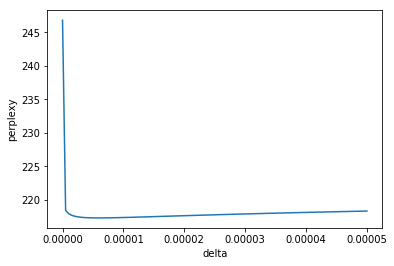

In [14]:
# Рисуем, чтобы удостовериться, что выбран правильный интервал поиска дельты

axis = plot.gca()
plot.plot(deltas, perplexities)
axis.set_xlabel('delta')
axis.set_ylabel('perplexy')

## Stupid backoff

Идея **простого отката** довольно понятна. Если у нас есть достаточно информцаии для подсчета вероятности $k$-грам, то будем использовать $k$-грамы. Иначе будем использовать вероятности $(k-1)$-грам с некоторым множителем, например, $0.4$, и так далее. К сожалению, в данном случае мы получим не вероятностное распределение, но в большинстве задач это не имеет принципиального значения. Если это все же важно, то необходимо подобрать множитель соответствующим образом.

Реализуйте класс, симулирующий сглаживание простым откатом. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [15]:
class StupidBackoffProbabilityEstimator:
    """Class for stupid backoff probability estimations.
    
    P(word | context) =
        P'(word | context),                  if  P'(word | context) > 0;
        P'(word | context[1:]) * multiplier, if  P'(word | context) == 0
                                             and P'(word | context[1:]) > 0;
        ...
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        multiplier (float): Multiplier which is used for probability estimations.
    """
    
    def __init__(self, base_estimator, multiplier=0.1):
        self.__base_estimator = base_estimator
        self.__mult = multiplier

    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) by one word.
        """
        if len(context) != 1:
            return context[1:]
        else:
            return tuple()
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        
        ### YOUR CODE HERE
        counter = 0
        while self.__base_estimator(word, context) == 0:
            context = self.cut_context(context)
            counter += 1
        return (self.__mult ** counter) * self.__base_estimator(word, context)
        ### END YOUR CODE
        
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [16]:
# Initialize estimator
sbackoff_estimator = StupidBackoffProbabilityEstimator(simple_estimator, .4)

# Let's make some estimations
print('Stupid backoff estimator perplexity = {}'.format(perplexity(sbackoff_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

Stupid backoff estimator perplexity = 119.80451760092832
1.48559186035e-05


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Почему бессмысленно измерять перплексию в случае **Stupid backoff**?  
**A:** Из-за тупого отнятия вероятности распределение перестает быть вероятностным (сумма всех вероятностей не единица). Перплексия, как вероятностная величина теряет значение.


## Interpolation smoothing

В данном случае идея сглаживания посредством **интерполяции** также крайне проста. Пусть у нас есть $N$-грамная модель. Заведем вектор $\bar\lambda = (\lambda_1, \dots, \lambda_N)$, такой, что $\sum_i\lambda_i = 1$ и $\lambda_i \geq 0$. Тогда

$$
    \hat P_{IS}(w_{N} \mid w_1^{N-1}) = \sum_{i=1}^N \lambda_i \hat P_{S}(w_N \mid w_{N-i+1}^{N-1}).
$$

Придумайте, как обойтись одним вектором $\bar\lambda$, т.е. пользоваться им как в случае контекста длины $N$, так и при контексте меньшей длины (например, в начале предложения). Если мы просто обрубим сумму, то у нас уже не будет вероятностное распределение, что, конечно же, плохо.

In [17]:
class InterpolationProbabilityEstimator:
    """Class for interpolation probability estimations.
    
    P(word | context) =
        lambda_N * P'(word | context) +
        lambda_{N-1} * P'(word | context[1:]) +
        ... +
        lambda_1 * P'(word)
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        lambdas (np.array[float]): Lambdas which are used for probability estimations.
    """
    
    def __init__(self, base_estimator, lambdas):
        self.lambdas = lambdas
        self.__base_estimator = base_estimator
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        
        ### YOUR CODE HERE
        def normalized(lambdas):
            lambdas_sum = sum(lambdas)
            return np.array([one_lambda / lambdas_sum for one_lambda in lambdas])
        current_lambdas = normalized(self.lambdas[(len(self.lambdas) - len(context) - 1):])
        return np.sum([
            one_lambda * self.__base_estimator(word, context[i:])
            for one_lambda, i in zip(reversed(current_lambdas), range(len(context) + 1))
        ])
        ### END YOUR CODE
        
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [18]:
import numpy as np

# Initialize estimator
interpol_estimator = InterpolationProbabilityEstimator(simple_estimator, np.array([0.2, 0.2, 0.6]))

# Let's make some estimations
print('Interpolation estimator perplexity = {}'.format(perplexity(interpol_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

Interpolation estimator perplexity = 222.91920746812715
1.48559186035e-05


Обучить значения параметров $\lambda$ можно с помощью EM-алгоритма, но мы не будем этого здесь делать.

## Kneser-Ney smoothing

Идея данного сглаживания заключается в том, что словам, которые участвуют в большом количестве контекстов, присваиваются большие вероятности, а те, которые используются в паре-тройке контекстов, получают маленькие вероятности. Формулы приведены на слайде 37 лекции.
Реализуйте данный подход.

In [ ]:
class KneserNeyProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = ...
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): KneserNey parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if len(context) + 1 > self.__storage.max_n:
            context = context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a string!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        
        ### YOUR CODE HERE
        prob = 1.
        ### END YOUR CODE
        
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [ ]:
# Initialize estimator
kn_estimator = KneserNeyProbabilityEstimator(storage)

# Estimating perplexity
print('Simple estimator perplexity = {}'.format(perplexity(kn_estimator, test_sents)))
print(simple_estimator.prob('To be'.split()))
print(simple_estimator.prob('To be or not to be'.split()))

## Определение языка документа

**Постановка задачи:**  
Одна из задач, которая может быть решена при помощи языковых моделей $-$ **определение языка документа**. Реализуйте два классификатора для определения языка документа:
1. Наивный классификатор, который будет учитывать частоты символов и выбирать язык текста по признаку: распределение частот символов "наиболее похоже" на распределение частот символов в выбранном языке.
2. Классификатор на основе языковых моделей. Сами придумайте, как он должен работать.  
_Подсказка_: лучше считать n-грамы не по словам, а по символам.

---

**Как представлены данные:**  
Во всех текстовых файлах на каждой строчке записано отдельное предложение.
1. В папке _data_ находятся две папки: _full_ и _plain_. В _full_ находятся тексты в той форме, что они были взяты из сети, в _plain_ находятся те же самые тексты, но с них сначала была снята диакритика, а затем русский и греческий тексты были транслитерованы в английский.
2. В каждой из папок _full_ и _plain_ находятся папки _train_ и _test_.
3. В _train_ находятся файлы с текстами с говорящими именами, например, _ru.txt_, _en.txt_.
4. В _test_ находятся файлы _1.txt_, _2.txt_, $\dots$ в которых хранятся тексты, язык которых нужно определить. В этой же папке находится файл _ans.csv_, в котором вы можете найти правильные ответы и проверить, насколько хорошо сработали Ваши алгоритмы.

---

**Что нужно сделать:**  
Напишите два своих классификатора (которые описаны в постановке задачи) и получите максимально возможное accuracy на test-сете. Разрешается использовать только _train_ для обучения.

---

**В данном задании мы не предоставляем стартового кода!**

In [ ]:
# Write the code and estimate accuracy of your method.
# Create your own classifiers.

### YOUR CODE HERE

### END YOUR CODE